# Small Simple CNN

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from datetime import datetime

In [3]:
class SmallSimpleCNN(nn.Module):
    def __init__(self, patch_size):
        super(SmallSimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.size_after_pool = (patch_size-4)//2
        self.fc1 = nn.Linear(12 * self.size_after_pool * self.size_after_pool, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 12 * self.size_after_pool * self.size_after_pool)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class LogisticRegression(nn.Module):
    def __init__(self, patch_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(patch_size * patch_size * 3, 2)
        self.patch_size = patch_size
    
    def forward(self, x):
        x = x.view(-1, self.patch_size * self.patch_size * 3)
        out = self.linear(x)
        return out
    
class SimpleCNN(nn.Module):
    def __init__(self, patch_size):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #W_out = (W_in - F + 2P)/S + 1
        self.size_after_pool = ((patch_size-4)//2 - 4)//2
        self.fc1 = nn.Linear(16 * self.size_after_pool * self.size_after_pool, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * self.size_after_pool * self.size_after_pool)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Parameters

In [4]:
dataset_path = '/pio/lscratch/1/i279076/Medical/small-medical-22.h5'
batch_size = 1024
num_workers = 4
lr = 0.001
log_interval = 50
epochs = 2

sum_threshold = 42.

### Data loader

In [5]:
import h5py

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [6]:
class SmallMedicalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, np.long(label)


class SmallMedicalLoader:
    def __init__(self, dataset_path, batch_size, num_workers=8, pin_memory=True):
        self.dataset_path = dataset_path
        self.loader_args = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

        with h5py.File(self.dataset_path, 'r') as f:
            self.train_images = f['train']['images'][...]
            self.train_labels = f['train']['labels'][...]

            self.test_images = f['test']['images'][...]
            self.test_labels = f['test']['labels'][...]

        self.train_dataset = SmallMedicalDataset(self.train_images, self.train_labels)
        self.test_dataset = SmallMedicalDataset(self.test_images, self.test_labels)

    def train_loader(self):
        return DataLoader(self.train_dataset, **self.loader_args)

    def test_loader(self):
        return DataLoader(self.test_dataset, shuffle=True, **self.loader_args)

In [7]:
loader = SmallMedicalLoader(dataset_path, batch_size)

train_loader = loader.train_loader()
test_loader = loader.test_loader()

# -------------

In [8]:
class MedicalDataset(Dataset):
    def __init__(self, images, masks, patch_size=22):
        self.images = images
        self.masks = masks
        
        self.patch_size = patch_size
        
        self.images_count, self.image_size, _, _ = self.images.shape
        self.patches_per_side = self.image_size - self.patch_size + 1
        self.patches_per_image = self.patches_per_side ** 2
    
    def __len__(self):
        return self.images_count * self.patches_per_image
    
    def __getitem__(self, idx):
        image_idx = idx // self.patches_per_image
        patch_idx = idx % self.patches_per_image
        
        image = self.images[image_idx]
        mask = self.masks[image_idx]
        
        y = patch_idx // self.patches_per_side
        x = patch_idx % self.patches_per_side
        
        patch = image[y: y + self.patch_size, x: x + self.patch_size].transpose(2, 0, 1) / 255.
        label = mask.item((y + self.patch_size // 2, x + self.patch_size // 2, 0)) // 255
        
        return (patch, label)
    
class MedicalLoader:
    def __init__(self, dataset_path, patch_size, batch_size, num_workers=8, pin_memory=True):
        self.dataset_path = dataset_path
        self.patch_size = patch_size

        self.loader_args = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

        with h5py.File(self.dataset_path, 'r') as f:
            self.train_images = f['train']['images'][...]
            self.train_masks = f['train']['masks'][...]

            self.test_images = f['test']['images'][...]
            self.test_masks = f['test']['masks'][...]

        self.train_dataset = MedicalDataset(self.train_images, self.train_masks, patch_size=patch_size)
        self.test_dataset = MedicalDataset(self.test_images, self.test_masks, patch_size=patch_size)
        
    def train_loader(self):
        return DataLoader(self.train_dataset, **self.loader_args)

    def test_loader(self):
        return DataLoader(self.test_dataset, shuffle=True, **self.loader_args)

In [9]:
medical_data = '/pio/lscratch/1/i279076/Medical/medical.h5'

In [10]:
medical_loader = MedicalLoader(medical_data, 22, 256)

#### Training

In [11]:
# train_loader = medical_loader.train_loader()
# test_loader = medical_loader.test_loader()

In [12]:
model = SmallSimpleCNN(22).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [13]:
for epoch in range(20):

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.007
[1,   101] loss: 0.138
[1,   201] loss: 0.063
[2,     1] loss: 0.000
[2,   101] loss: 0.054
[2,   201] loss: 0.050
[3,     1] loss: 0.000
[3,   101] loss: 0.048
[3,   201] loss: 0.046
[4,     1] loss: 0.000
[4,   101] loss: 0.044
[4,   201] loss: 0.043
[5,     1] loss: 0.000
[5,   101] loss: 0.043
[5,   201] loss: 0.041
[6,     1] loss: 0.000
[6,   101] loss: 0.042
[6,   201] loss: 0.041
[7,     1] loss: 0.000
[7,   101] loss: 0.041
[7,   201] loss: 0.040
[8,     1] loss: 0.000
[8,   101] loss: 0.040
[8,   201] loss: 0.039
[9,     1] loss: 0.000
[9,   101] loss: 0.039
[9,   201] loss: 0.038
[10,     1] loss: 0.000
[10,   101] loss: 0.038
[10,   201] loss: 0.037
Finished Training


In [14]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

with torch.no_grad():
    for (images, labels) in test_loader:
        images, labels = images.cuda(), labels.cuda()
        
        outputs = model(images.float())
        _, predicted = torch.max(outputs, 1)
        
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

classes = ['negative', 'positive']
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of negative : 99 %
Accuracy of positive : 43 %


In [15]:
class ImageDataset(Dataset):
    def __init__(self, image, mask, patch_size=22):
        image_size, _, _ = image.shape
        size = image_size + patch_size - 1
        offset = patch_size // 2
        
        extended_image = np.zeros((size, size, 3))
        extended_image[offset: offset + image_size, offset: offset + image_size] = image
        
        extended_mask = np.zeros((size, size, 1))
        extended_mask[offset: offset + image_size, offset: offset + image_size] = mask
        
        self.image = extended_image
        self.mask = extended_mask
        
        self.patch_size = patch_size
        
        self.image_size, _, _ = self.image.shape
        self.patches_per_side = self.image_size - self.patch_size + 1
        self.patches_per_image = self.patches_per_side ** 2
    
    def __len__(self):
        return self.patches_per_image
    
    def __getitem__(self, idx):                
        y = idx // self.patches_per_side
        x = idx % self.patches_per_side
        
        patch = self.image[y: y + self.patch_size, x: x + self.patch_size].transpose(2, 0, 1) / 255.
        label = self.mask.item((y + self.patch_size // 2, x + self.patch_size // 2, 0)) // 255
        
        return (patch, label)

In [16]:
indices = [i for i in range(len(medical_loader.test_masks)) if medical_loader.test_masks[i].sum() > 0]

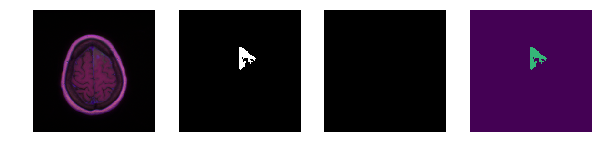

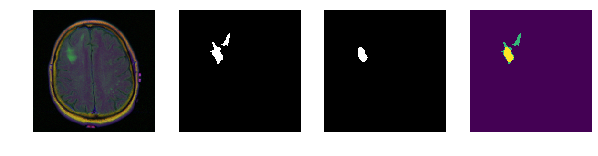

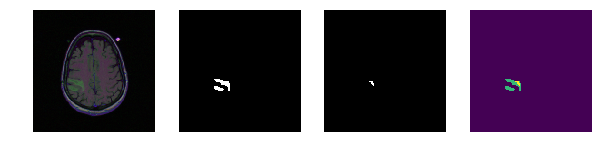

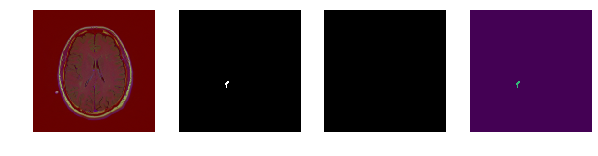

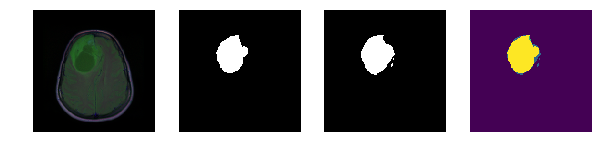

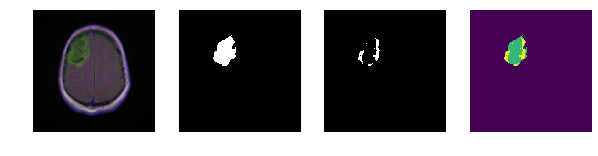

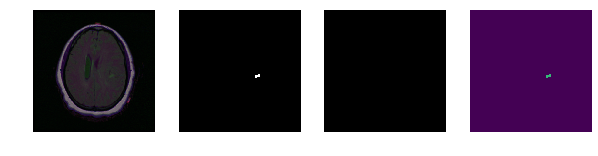

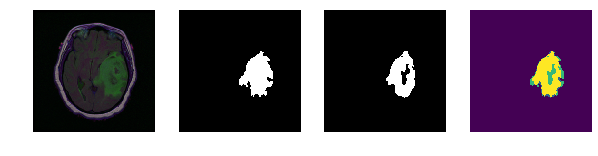

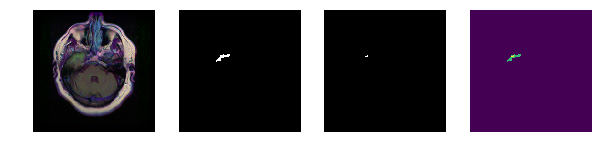

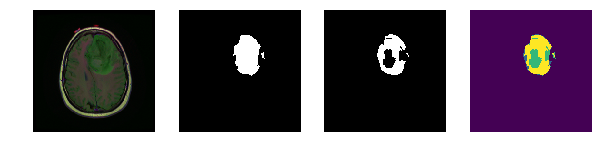

In [17]:
for idx in np.random.choice(indices, 10, replace=False):
    image = medical_loader.test_images[idx]
    mask = medical_loader.test_masks[idx]
    
    image_loader = DataLoader(ImageDataset(image, mask, 22), batch_size=128, num_workers=8)
    
    predicted_mask = []

    with torch.no_grad():
        for (images, labels) in image_loader:
            images, labels = images.cuda(), labels.cuda()

            outputs = model(images.float())
            _, predicted = torch.max(outputs, 1)

            predicted[images.reshape(-1, 22 * 22 * 3).sum(1) < sum_threshold] = 0
            predicted_mask.extend(predicted.cpu().numpy())
            
    recon_mask = np.array(predicted_mask).reshape(256, 256)
    mask = mask.squeeze() // 255
    
#     common_mask = np.logical_and(recon_mask, mask) * 1.0
    
    plt.figure(figsize=(10, 3))
    plt.subplot(141)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(recon_mask, cmap='gray')
    plt.axis('off')
    plt.subplot(144)
    plt.imshow(2 * mask + recon_mask, vmin=0, vmax=3)
    plt.axis('off')
    plt.show()

In [18]:
processed_images = []

for idx in np.random.choice(len(medical_loader.test_masks), 1100, replace=False):
    image = medical_loader.test_images[idx]
    mask = medical_loader.test_masks[idx]
    
    image_loader = DataLoader(ImageDataset(image, mask, 22), batch_size=512, num_workers=8)
    
    predicted_mask = []

    with torch.no_grad():
        for (images, labels) in image_loader:
            images, labels = images.cuda(), labels.cuda()

            outputs = model(images.float())
            _, predicted = torch.max(outputs, 1)

            predicted[images.reshape(-1, 22 * 22 * 3).sum(1) < sum_threshold] = 0
            predicted_mask.extend(predicted.cpu().numpy())
            
    recon_mask = np.array(predicted_mask).reshape(256, 256)
    mask = mask.squeeze() // 255
    
#     common_mask = np.logical_and(mask, recon_mask) * 1.0
    processed_images.append((image, mask, recon_mask))

żółty - część wspólna, zielony - tylko w oryginale, niebieski - tylko w rekonstrukcji


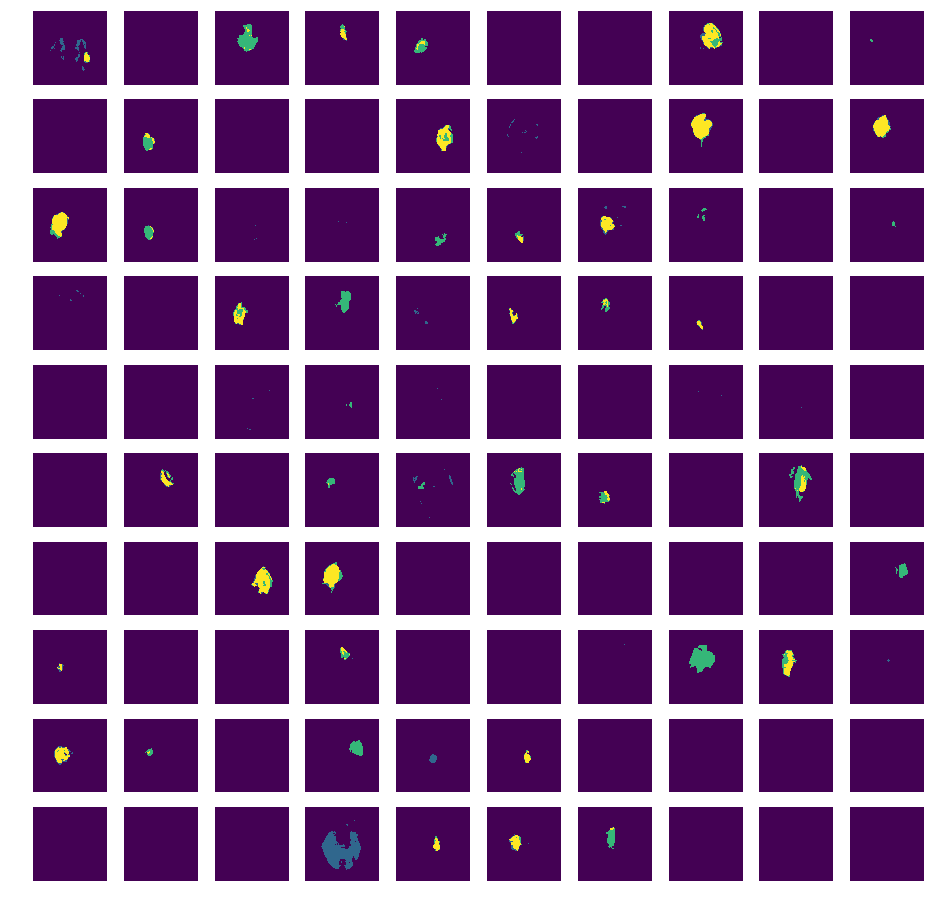

In [48]:
plt.figure(figsize=(16, 16))
print('żółty - część wspólna, zielony - tylko w oryginale, niebieski - tylko w rekonstrukcji')

for i, (_, mask, recon_mask) in enumerate(processed_images[:100], 1):    
    plt.subplot(10, 10, i)
    plt.imshow(2 * mask + recon_mask, vmin=0, vmax=3)
    plt.axis('off')
    
plt.show()

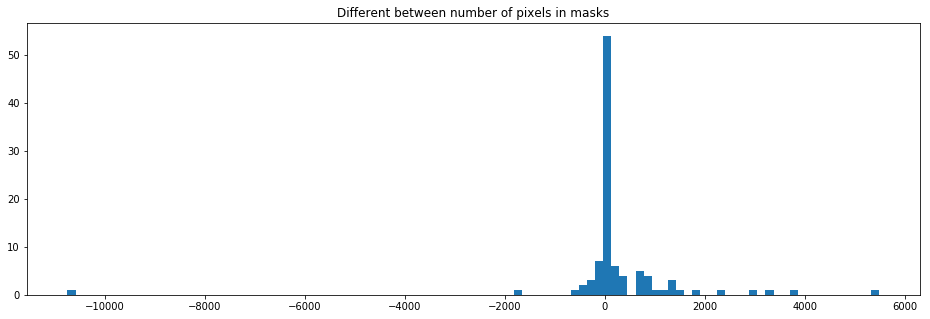

In [66]:
plt.figure(figsize=(16, 5))
plt.hist([mask.sum() - recon_mask.sum() for _, mask, recon_mask in processed_images], bins=100)
plt.title('Different between number of pixels in masks')
plt.show()

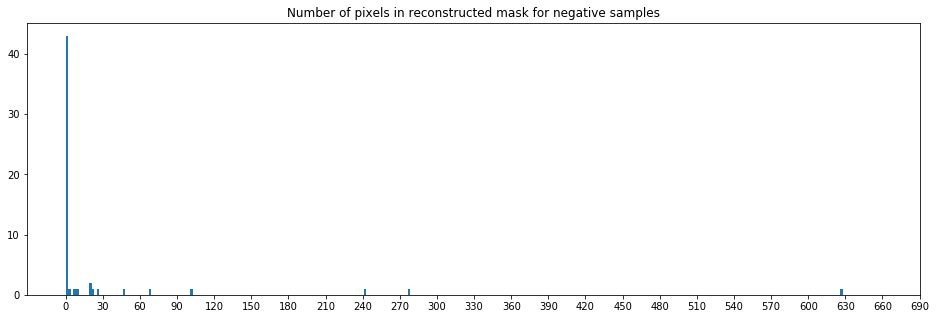

In [65]:
plt.figure(figsize=(16, 5))
plt.hist([recon_mask.sum() for _, mask, recon_mask in processed_images if mask.sum() == 0 and recon_mask.sum() < 700], bins=300)
plt.xticks(range(0, 700, 30))
plt.title('Number of pixels in reconstructed mask for negative samples')
plt.show()

In [19]:
cm = np.zeros((2, 2))

for image, mask, recon_mask in processed_images:
    common_mask = np.logical_and(mask, recon_mask) * 1.0
    
    cm[min(mask.sum(), 1), min(recon_mask.sum(), 1)] += 1

[[42. 15.]
 [ 8. 35.]]


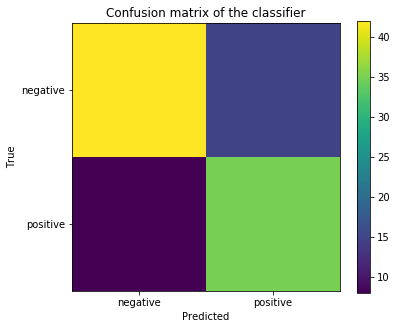

In [20]:
labels = ['negative', 'positive']
print(cm)

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [45]:
stats = []

for image, mask, recon_mask in processed_images:
    common_mask = np.logical_and(mask, recon_mask) * 1.0
    
    mv = (mask.sum() - common_mask.sum()) / mask.sum() if mask.sum() != 0 else 0
    rv = (recon_mask.sum() - common_mask.sum()) / recon_mask.sum() if recon_mask.sum() != 0 else 0
    
    stats.append((mv, rv))

[]

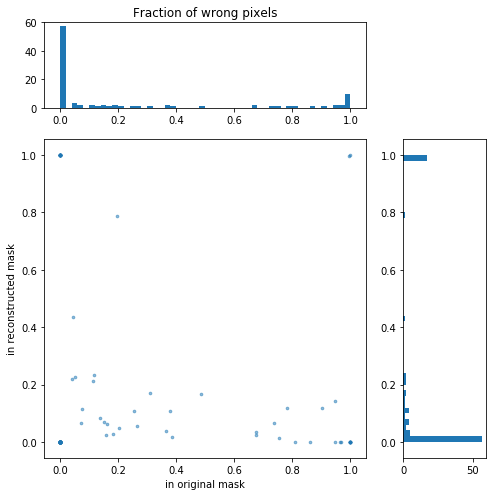

In [46]:
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(4, 4)

ax_main = plt.subplot(gs[1:4, :3])
ax_xDist = plt.subplot(gs[0, :3], sharex=ax_main)
ax_yDist = plt.subplot(gs[1:4, 3], sharey=ax_main)

X, Y = zip(*stats)

ax_main.scatter(X, Y, alpha=0.5, s=7)
ax_xDist.hist(X, bins=50)
ax_yDist.hist(Y, bins=50, orientation='horizontal')

ax_main.set(xlabel='in original mask', ylabel='in reconstructed mask')
ax_xDist.set(title='Fraction of wrong pixels')

plt.tight_layout()
plt.plot()

In [23]:
from collections import Counter

neigh = Counter()
neigh_all = Counter()

for image, mask, recon_mask in processed_images:
    common_mask = np.logical_and(mask, recon_mask) * 1.0
    
    for x, y in [(x, y) for x in range(256) for y in range(256)]:
        m = mask[x-1: x+2, y-1: y+2].sum()
        if mask[x, y] != recon_mask[x, y]:
            neigh[m] += 1
        neigh_all[m] += 1

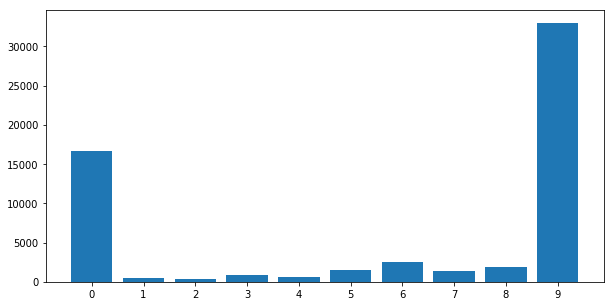

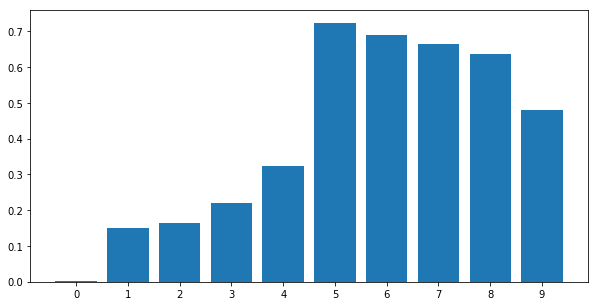

In [24]:
plt.figure(figsize=(10, 5))
plt.bar(neigh.keys(), neigh.values())
plt.xticks(range(10))
plt.show()

foo = {i: neigh[i] / neigh_all[i] for i in neigh_all.keys()}

plt.figure(figsize=(10, 5))
plt.bar(foo.keys(), foo.values())
plt.xticks(range(10))
plt.show()